In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(trainset.classes)
print(len(trainset.classes))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


50000
torch.Size([3, 32, 32]) 9


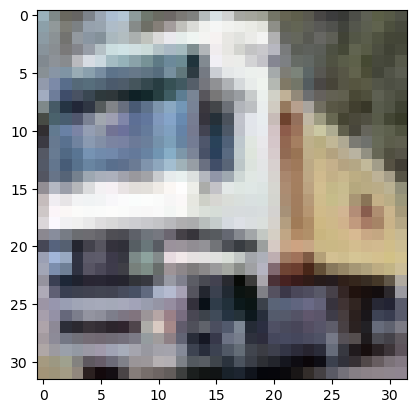

In [23]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[1][1])
sample = np.transpose(trainset[1][0], (1,2,0))
plt.imshow(sample)
# plt.imshow(trainset[0][0][0], cmap='gray')

In [5]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [7]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

In [9]:
from torch.optim import SGD, Adam

lr = 0.001

model_opt_sgd = Model(3 * 32 * 32, 1024)
model_opt_adam = Model(3 * 32 * 32, 1024)

model_opt_sgd = model_opt_sgd.to('cuda')
model_opt_adam = model_opt_adam.to('cuda')

optimizer_sgd = SGD(model_opt_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_opt_adam.parameters(), lr=lr)

In [11]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [57]:
def train(model, optimizer, trainloader, testloader=None):
    n_epochs = 50
    train_accs = []
    test_accs = []
    for epoch in range(n_epochs):
      total_loss = 0.
    
      model.train()
      for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
    
        preds = model(inputs)
        CEL = torch.nn.CrossEntropyLoss()
        loss = CEL(preds, labels)
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
    
      with torch.no_grad():
        model.eval()
        train_accs.append(accuracy(model, trainloader))
        if testloader: test_accs.append(accuracy(model, testloader))
    
      print(f"Epoch {epoch:3d} | Loss: {total_loss}")
        
    if testloader:
        return train_accs, test_accs
    else:
        return train_accs

In [15]:
sgd_train = train(model_opt_sgd, optimizer_sgd, trainloader)
adam_train = train(model_opt_adam, optimizer_adam, trainloader)

Epoch   0 | Loss: 449.9595329761505
Epoch   1 | Loss: 447.8079650402069
Epoch   2 | Loss: 446.02727246284485
Epoch   3 | Loss: 444.2843163013458
Epoch   4 | Loss: 442.49400663375854
Epoch   5 | Loss: 440.5787990093231
Epoch   6 | Loss: 438.4815933704376
Epoch   7 | Loss: 436.2168927192688
Epoch   8 | Loss: 433.80255651474
Epoch   9 | Loss: 431.19646167755127
Epoch  10 | Loss: 428.36613726615906
Epoch  11 | Loss: 425.45617175102234
Epoch  12 | Loss: 422.46991205215454
Epoch  13 | Loss: 419.4887776374817
Epoch  14 | Loss: 416.5616612434387
Epoch  15 | Loss: 413.79618525505066
Epoch  16 | Loss: 411.15643525123596
Epoch  17 | Loss: 408.6629230976105
Epoch  18 | Loss: 406.37476348876953
Epoch  19 | Loss: 404.1794378757477
Epoch  20 | Loss: 402.07044184207916
Epoch  21 | Loss: 400.19711315631866
Epoch  22 | Loss: 398.4125587940216
Epoch  23 | Loss: 396.6600331068039
Epoch  24 | Loss: 394.99111557006836
Epoch  25 | Loss: 393.5054545402527
Epoch  26 | Loss: 392.0848240852356
Epoch  27 | Loss: 

In [25]:
from matplotlib import pyplot as plt

def showPlot(*results):
    for result in results:
        data = result['data']
        label = result['label']
        x = np.arange(len(data))
        plt.plot(x, data, label=label)
    plt.legend()
    plt.show()

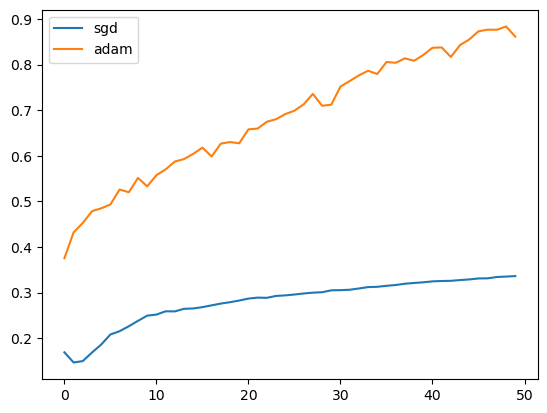

In [59]:
showPlot({'label': 'sgd', 'data': sgd_train}, {'label': 'adam', 'data': adam_train})

In [63]:
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.Sigmoid()

    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        
        return x

In [65]:
lr = 0.001

sigModel = SigmoidModel(3 * 32 * 32, 1024)
leakyReluModel = Model(3 * 32 * 32, 1024)

sigModel = sigModel.to('cuda')
leakyReluModel = leakyReluModel.to('cuda')

optim_for_sig = Adam(sigModel.parameters(), lr=lr)
optim_for_leaky = Adam(leakyReluModel.parameters(), lr=lr)

In [67]:
sig_train = train(sigModel, optim_for_sig, trainloader)
leaky_train = train(leakyReluModel, optim_for_leaky, trainloader)

Epoch   0 | Loss: 386.302947640419
Epoch   1 | Loss: 338.0867223739624
Epoch   2 | Loss: 321.39596951007843
Epoch   3 | Loss: 308.3180853128433
Epoch   4 | Loss: 299.0466593503952
Epoch   5 | Loss: 292.4270465373993
Epoch   6 | Loss: 285.94172644615173
Epoch   7 | Loss: 277.90055108070374
Epoch   8 | Loss: 274.2808119058609
Epoch   9 | Loss: 270.04654014110565
Epoch  10 | Loss: 265.48529863357544
Epoch  11 | Loss: 260.8406537771225
Epoch  12 | Loss: 256.1607987880707
Epoch  13 | Loss: 252.0372599363327
Epoch  14 | Loss: 249.09028351306915
Epoch  15 | Loss: 245.77544176578522
Epoch  16 | Loss: 242.1152148246765
Epoch  17 | Loss: 236.8674818277359
Epoch  18 | Loss: 234.16846811771393
Epoch  19 | Loss: 230.83807939291
Epoch  20 | Loss: 227.03324854373932
Epoch  21 | Loss: 224.60682648420334
Epoch  22 | Loss: 220.79260301589966
Epoch  23 | Loss: 218.2599087357521
Epoch  24 | Loss: 214.11424738168716
Epoch  25 | Loss: 211.02789318561554
Epoch  26 | Loss: 206.79337227344513
Epoch  27 | Loss:

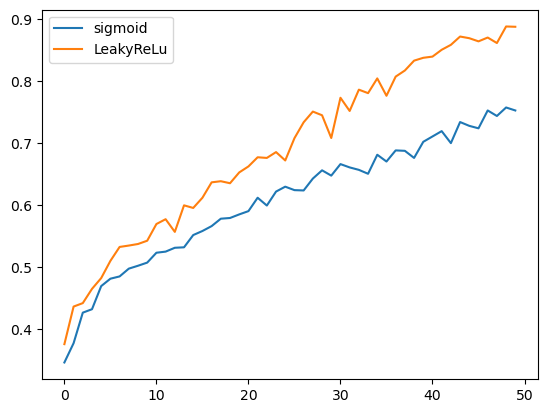

In [69]:
showPlot({'label': 'sigmoid', 'data': sig_train}, {'label': 'LeakyReLu', 'data': leaky_train})

In [73]:
class DropoutModel(nn.Module):
    
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)

        return x

In [75]:
dropoutModel = DropoutModel(3 * 32 * 32, 1024)
dropoutModel = dropoutModel.to('cuda')

optim_with_drop = Adam(dropoutModel.parameters(), lr=lr)

In [77]:
train, test = train(dropoutModel, optim_with_drop, trainloader, testloader)

Epoch   0 | Loss: 369.88279688358307
Epoch   1 | Loss: 332.46503376960754
Epoch   2 | Loss: 315.1964387893677
Epoch   3 | Loss: 304.7842319011688
Epoch   4 | Loss: 296.100413441658
Epoch   5 | Loss: 290.7852793931961
Epoch   6 | Loss: 284.931515455246
Epoch   7 | Loss: 280.1321415901184
Epoch   8 | Loss: 272.80698812007904
Epoch   9 | Loss: 269.6558561325073
Epoch  10 | Loss: 265.22994232177734
Epoch  11 | Loss: 261.4298459291458
Epoch  12 | Loss: 256.63942790031433
Epoch  13 | Loss: 253.4547746181488
Epoch  14 | Loss: 250.62121284008026
Epoch  15 | Loss: 247.88246834278107
Epoch  16 | Loss: 244.80556738376617
Epoch  17 | Loss: 241.0575431585312
Epoch  18 | Loss: 237.54454362392426
Epoch  19 | Loss: 235.29757463932037
Epoch  20 | Loss: 230.743197619915
Epoch  21 | Loss: 227.4626853466034
Epoch  22 | Loss: 225.5560012459755
Epoch  23 | Loss: 222.78997600078583
Epoch  24 | Loss: 219.64757108688354
Epoch  25 | Loss: 216.54809951782227
Epoch  26 | Loss: 212.92072224617004
Epoch  27 | Loss:

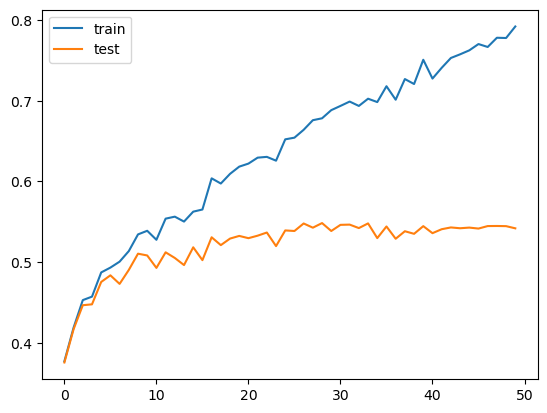

In [79]:
showPlot({'label': 'train', 'data': train}, {'label': 'test', 'data': test})